In [1]:

from dwdynamics import ComplexDynamicsProblem, Objective,helpers,fixed_point,instance # Difference a. We are using ComplexDynamicsProblem
from dimod import ExactSolver
import numpy as np
import scipy
import pandas as pd
import numpy as np
import scipy as sp
import math
import qutip as qp
import dimod
import pandas as pd
from collections import defaultdict
import re
from dwave.system import DWaveSampler, EmbeddingComposite
import dwave.inspector

In [2]:
# Let's compute baseline using QuTiP
import qutip as qp

#instance = 8
#PSI0_2 = np.array([1,0,0,0],dtype=np.complex128)
#instance_dict = helpers.get_instance(instance)
#H = instance_dict['H']
#PSI0 = instance_dict['psi0']

i = instance.Instance(8)
i.create_instance(precision=3,number_time_points=2)
qubo = i.get_qubo()



-------
sigma_y
---------
---------
array([[ 0.54030231+0.j, -0.84147098+0.j],
       [ 0.84147098+0.j,  0.54030231+0.j]])
------


In [3]:
exact_solver = ExactSolver()            
exact_result = exact_solver.sample(qubo)      
print(exact_result.first.energy)

psi_0 = qp.basis(2, 0)

times = np.linspace(0, 1, 100)
baseline = qp.mesolve(qp.Qobj(i.H), psi_0, times, e_ops=[qp.sigmaz()]).expect[0]
# Define sigma_z for manual computation of expected values
SZ = np.array([[1, 0], [0, -1]])

# decode_sample returns flat vector, we use reshape to form an 6x2 array of states
exact_vec = i.problem.interpret_sample(exact_result.first.sample)

# Difference d.: We use complex conjugation to compute expected values. For this example it shouldn't matter though.
# Then, for the expectation values we take only the real part, because otherwise matplotlib would complain.
exact_expect = [(state.conj() @ SZ @ state).real for state in exact_vec]
from matplotlib import pyplot as plt
print(exact_expect)

0.053511449032142444
[np.float64(1.0), np.float64(-0.75)]


In [4]:
exact_result.first.sample

{0: np.int8(1),
 1: np.int8(0),
 2: np.int8(0),
 3: np.int8(0),
 4: np.int8(1),
 5: np.int8(0),
 6: np.int8(0),
 7: np.int8(1),
 8: np.int8(0),
 9: np.int8(0),
 10: np.int8(1),
 11: np.int8(0),
 12: np.int8(0),
 13: np.int8(1),
 14: np.int8(1),
 15: np.int8(0),
 16: np.int8(1),
 17: np.int8(0),
 18: np.int8(1),
 19: np.int8(0),
 20: np.int8(0),
 21: np.int8(0),
 22: np.int8(1),
 23: np.int8(0)}

In [5]:
helpers.result_string_to_dict('111000')

{0: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1}

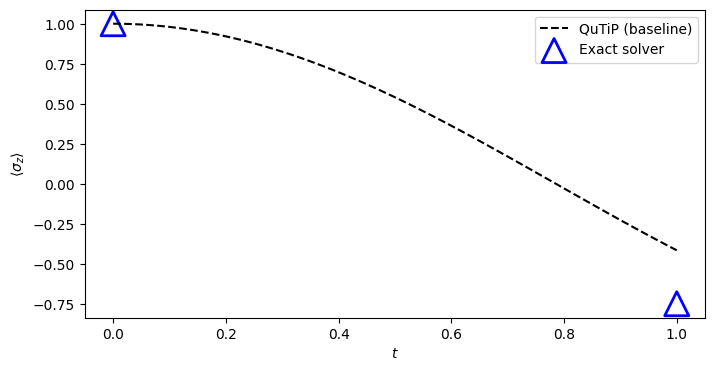

In [6]:
fig, axis = plt.subplots(figsize=(8, 4))

axis.plot(times, baseline, "k--", label="QuTiP (baseline)")

axis.scatter(i.problem.times, exact_expect, marker="^", lw=2, s=300, edgecolors="b", facecolors="none", label="Exact solver")

axis.set_ylabel(r"$\langle \sigma_z \rangle$")
axis.set_xlabel("$t$")
axis.legend()
plt.show()

In [8]:
df = i.get_xubo_df()

for _,(energy,state) in df.head(10).iterrows():
    print(energy)
    sample_vec = i.problem.interpret_sample(helpers.result_string_to_dict(state))
    print(sample_vec)
    exact_expect = [(state.conj() @ SZ @ state).real for state in sample_vec]
    print(exact_expect)
    print("---------")

    

-45.22506735776202
[[1. +0.j 0. +0.j]
 [0.5+0.j 1. +0.j]]
[np.float64(1.0), np.float64(-0.75)]
---------
-45.14614028835405
[[1.5+0.j 0. +0.j]
 [1. +0.j 1.5+0.j]]
[np.float64(2.25), np.float64(-1.25)]
---------
-45.08668949550396
[[ 1. +0.j -0.5+0.j]
 [ 1. +0.j  0.5+0.j]]
[np.float64(0.75), np.float64(0.75)]
---------
-45.047727293776155
[[1. +0.j  0. +0.5j]
 [0.5-0.5j 1. +0.5j]]
[np.float64(0.75), np.float64(-0.75)]
---------
-45.04772729377612
[[1. +0.j  0. -0.5j]
 [0.5+0.5j 1. -0.5j]]
[np.float64(0.75), np.float64(-0.75)]
---------
-45.04772729377609
[[1. -0.5j 0. +0.j ]
 [0.5-0.5j 1. -0.5j]]
[np.float64(1.25), np.float64(-0.75)]
---------
-45.04772729377609
[[1. +0.5j 0. +0.j ]
 [0.5+0.5j 1. +0.5j]]
[np.float64(1.25), np.float64(-0.75)]
---------
-45.04212538814618
[[1. +0.j 0. +0.j]
 [0.5+0.j 0.5+0.j]]
[np.float64(1.0), np.float64(0.0)]
---------
-45.028578806794144
[[0.5+0.j 0. +0.j]
 [0. +0.j 0. +0.j]]
[np.float64(0.25), np.float64(0.0)]
---------
-45.01536966363017
[[1. +0.j 0.

In [ ]:
state = 1/math.sqrt(2) * np.array([1,1])
print(state)
state= np.array([3/5,4/5])
(state.conj() @ SZ @ state).real

[0.70710678 0.70710678]


np.float64(-0.28000000000000014)

# Analyze Velox results

In [56]:
system=8
df = pd.read_csv(f'../data/results/pruned/{system}/best_results_pruned_{system}_native.csv')
df

,type,instance,num_var,num_rep,num_steps,compress,runtime,gap,best_energy,gnd_energy,success_prob,best_solution
0,8,precision_3_timepoints_2.coo,24,8,1000,False,0.044592,0.815466,-44.909348,-45.278579,0.000000,1;-1;-1;-1;1;-1;-1;-1;1;-1;1;1;1;-1;-1;-1;-1;1...
1,8,precision_3_timepoints_3.coo,36,8,1000,False,0.038975,1.161899,-77.766289,-78.680477,0.000000,1;-1;-1;-1;1;1;-1;-1;-1;-1;-1;1;1;1;-1;1;-1;-1...
2,8,precision_3_timepoints_4.coo,48,8,1000,False,0.041943,0.615028,-111.393036,-112.082374,0.000000,1;-1;1;-1;1;-1;-1;-1;1;-1;1;-1;1;-1;1;-1;1;-1;...
3,8,precision_4_timepoints_2.coo,32,8,1000,False,0.026843,1.373260,-47.947437,-48.615048,0.000000,1;-1;-1;-1;1;-1;-1;-1;-1;-1;1;1;-1;-1;1;1;1;-1...
4,8,precision_4_timepoints_3.coo,48,8,1000,False,0.035689,0.697685,-82.499115,-83.078743,0.000000,1;-1;-1;-1;-1;1;-1;-1;-1;1;-1;-1;-1;-1;1;1;-1;...
...,...,...,...,...,...,...,...,...,...,...,...,...
379,8,precision_5_timepoints_3.coo,60,262144,10000,False,20.362079,0.012313,-85.280037,-85.290538,0.000381,1;-1;-1;-1;1;-1;1;-1;-1;-1;-1;1;-1;-1;-1;-1;1;...
380,8,precision_6_timepoints_2.coo,48,262144,10000,False,19.734443,0.015501,-51.226341,-51.234283,0.029755,-1;1;1;1;1;1;-1;-1;1;1;1;1;-1;-1;1;1;1;1;-1;1;...
381,8,precision_6_timepoints_3.coo,72,262144,10000,False,18.235491,0.022064,-86.380539,-86.399602,0.001526,1;-1;-1;-1;-1;-1;-1;1;-1;-1;-1;1;-1;1;-1;-1;-1...
382,8,precision_7_timepoints_2.coo,56,262144,10000,False,20.136219,0.016005,-51.672291,-51.680562,0.049591,-1;1;1;1;1;1;-1;-1;-1;1;1;1;1;-1;-1;-1;1;1;1;1...


In [57]:
df_dict= defaultdict(list)
for row in df.itertuples():
    precision, timepoints = re.findall(r'\d+',str(row.instance))
    df_dict['precision'].append(int(precision))
    df_dict['timepoints'].append(int(timepoints))
    df_dict['gap'].append(float(row.gap))
    df_dict['solution'].append(row.best_solution.replace("-1","0").replace(';',''))
df_cleaned = pd.DataFrame(df_dict).sort_values('gap',ascending=True).drop_duplicates()
df_cleaned

,precision,timepoints,gap,solution
368,6,2,0.010103,011111010000001111010000011001010000011011010000
354,5,2,0.010937,1000001000010000100001100010000111101000
370,7,2,0.011193,0111101010000000111110100000011000001000000110...
358,7,2,0.011739,0111111010000101000100100010010111000111100111...
379,5,3,0.012313,1000101000010000100001101010001000001000001000...
...,...,...,...,...
0,3,2,0.815466,100010001011100001011011
14,3,4,0.857308,011001001010011001010000011100010000011101011011
196,7,2,0.892210,1000011010011001000100110111010110100000011000...
1,3,3,1.161899,100011000001110100010010101100110100


In [61]:
precision = 7
timepoints = 3

df_filtered =  df_cleaned[(df_cleaned.precision == precision) & (df_cleaned.timepoints == timepoints)]
df_filtered

,precision,timepoints,gap,solution
383,7,3,0.020167,1000001010001001001000011111010110101000110111...
359,7,3,0.031836,1000000001111101000100100000010110100111110111...
365,7,3,0.038039,1000000001111100111110011010011001101010000111...
371,7,3,0.038609,1000000001110100111010100001011010100110010111...
347,7,3,0.039758,0111001001111101000010100000010101100111110110...
335,7,3,0.040443,0111111010000000111100100010011011000111010111...
275,7,3,0.045005,1000011001110001000010100000011000100111111000...
353,7,3,0.054568,1000000010000001000110100010010110000110110111...
215,7,3,0.056762,0111011010010100110100011101011010101010010101...
377,7,3,0.057358,1000000010010101000110100010010111100111110111...


-------
sigma_y
---------
---------
array([[ 0.54030231+0.j, -0.84147098+0.j],
       [ 0.84147098+0.j,  0.54030231+0.j]])
------
-------
sigma_y
---------
---------
array([[ 0.54030231+0.j, -0.84147098+0.j],
       [ 0.84147098+0.j,  0.54030231+0.j]])
------
---------
array([[ 0.54030231+0.j, -0.84147098+0.j],
       [ 0.84147098+0.j,  0.54030231+0.j]])
------
-------
sigma_y
---------
---------
array([[ 0.54030231+0.j, -0.84147098+0.j],
       [ 0.84147098+0.j,  0.54030231+0.j]])
------
---------
array([[ 0.54030231+0.j, -0.84147098+0.j],
       [ 0.84147098+0.j,  0.54030231+0.j]])
------
---------
array([[ 0.54030231+0.j, -0.84147098+0.j],
       [ 0.84147098+0.j,  0.54030231+0.j]])
------


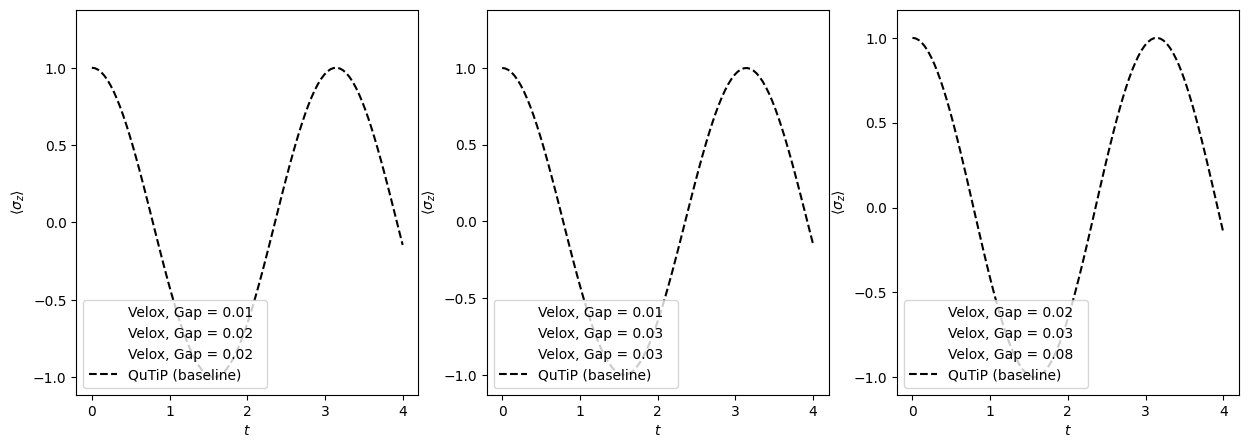

In [ ]:

plot_rows =  1
plot_columns = 3
# Create a single axis for the plot
fig, axes = plt.subplots(plot_rows, plot_columns, figsize=(5*plot_columns, 5*plot_rows), sharey=False)

SZ = np.array([[1, 0], [0, -1]])  
axes = axes.flatten()
tp_pairs = [(6,2),(5,3),(4,4)]

for i, (precision,timepoints) in enumerate(tp_pairs):
    ax = axes[i]

    inst_obj = instance.Instance(system)

    inst_obj.create_instance(precision=precision,number_time_points=timepoints)
    qubo = inst_obj.get_qubo()


    df_filtered =  df_cleaned[(df_cleaned.precision == precision) & (df_cleaned.timepoints == timepoints)]
    for j in [0,1,2]:
        raw_sample = df_filtered['solution'].values[j][::-1]
        gap = round(df_filtered['gap'].values[j],ndigits=2)
        sample_str = helpers.result_string_to_dict(raw_sample)
        sample_vec = inst_obj.problem.interpret_sample(sample_str)
        exact_expect = [(state.conj() @ SZ @ state).real for state in sample_vec]
        ax.scatter(inst_obj.problem.times, exact_expect, color=colors[j % len(colors)], marker=markers[j % len(markers)], lw=2, s=300, facecolors="none", label=f"Velox, Gap = {gap}  ")


    psi_0 = qp.basis(2, 0)

    times = np.linspace(0, 4, 100)
    baseline = qp.mesolve(qp.Qobj(inst_obj.H), psi_0, times, e_ops=[qp.sigmaz()]).expect[0]
     

    # Difference d.: We use complex conjugation to compute expected values. For this example it shouldn't matter though.
    # Then, for the expectation values we take only the real part, because otherwise matplotlib would complain.
    ax.plot(times, baseline, "k--", label="QuTiP (baseline)")

    ax.set_ylabel(r"$\langle \sigma_z \rangle$")
    ax.set_xlabel("$t$")
    ax.legend(loc="lower left")
plt.show()

In [33]:
exact_solver = ExactSolver()            
exact_result = exact_solver.sample(qubo)
(exact_result.first)

Sample(sample={0: np.int8(1), 1: np.int8(0), 2: np.int8(0), 3: np.int8(1), 4: np.int8(0), 5: np.int8(1), 6: np.int8(0), 7: np.int8(1), 8: np.int8(0), 9: np.int8(1), 10: np.int8(0), 11: np.int8(1), 12: np.int8(1), 13: np.int8(0), 14: np.int8(0), 15: np.int8(1)}, energy=np.float64(0.0), num_occurrences=np.int64(1))

In [43]:
dw_sampler = EmbeddingComposite(DWaveSampler( solver="Advantage_system5.4", region="eu-central-1", ))
dw_result = dw_sampler.sample(qubo, num_reads=1, annealing_time=200,return_embedding=True)
dwave.inspector.show(dw_result)

Serving Inspector on http://127.0.0.1:18000/?problemId=fc0907c9-9216-439f-8ab7-0f91be8363cb

'http://127.0.0.1:18000/?problemId=fc0907c9-9216-439f-8ab7-0f91be8363cb'

In [44]:
dw_result.info['embedding_context']

{'embedding': {1: (527,),
  0: (512,),
  8: (3422,),
  9: (3437,),
  3: (563,),
  2: (4442,),
  10: (548,),
  11: (4457,),
  5: (125,),
  4: (4005,),
  12: (3990,),
  13: (140,),
  7: (3414,),
  6: (3399,),
  14: (1802,),
  15: (1817,)},
 'chain_break_method': 'majority_vote',
 'embedding_parameters': {},
 'chain_strength': 9.231698354040821}